In [1]:
using Plots
include("polyfit_function.jl")

polyfit (generic function with 1 method)

In [2]:
using LinearAlgebra, DSP, Polynomials
function Lagrange(t, g, a, b)
    N=length(t)
    p=zeros(ComplexF64,1, N)
    L=zeros(ComplexF64, N ,N)
    cpoly=zeros(ComplexF64, 1, N)
    intcpoly=zeros(ComplexF64, 1, N)
    pval=zeros(ComplexF64, N)
    dt=b-a
    s=(t .-a) / dt
    d=0
    for i in 1:N
        p=[1]
        for j in 1:N
            if i !=j
                p = conv(p, [-s[j], 1]) / (s[i] - s[j])
            end
        end
        L[i,:]=p
        cpoly=Polynomial(p)
        intcpoly=integrate(cpoly)
        pval[i]= g[i] * (intcpoly(1) - intcpoly(0))
        d = d .+ pval[i] 
    end
    apprx=dt*d
    return apprx
end

Lagrange (generic function with 1 method)

In [3]:
# Two-step Adams Bashforth Scheme (Explicit)

function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(ComplexF64, N + 1, 1)
    y[1] = y0
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

In [4]:
function ridc_step(f, tspan, y0 , N)
    
 
    K = 2
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y = zeros(ComplexF64, 1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
    
    for k in 1:K
        y[1, 1, k+1]= y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal RK2 (Explicit)
        Qdr=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[1], t[2]) # Quadrature
        
        k1= h*(f(t[1], y[1, 1, k+1])- f(t[1], y[1, 1, k]))
        k2= h*(f(t[1] + h, y[1, 1, k+1] + k1 + Qdr) - f(t[1]+h, y[1, 2, k])) 
        
        y[1, 2, k+1]=y[1, 1, k+1] + k1/2 + k2/2 + Qdr
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Q
        end
        
        for j in (2*k+2):(N+1)
            Q = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Q
        end
            
    end
   
    return y[1, N+1, K+1]
end

ridc_step (generic function with 1 method)

 N=6, p= 4.3380574462131145
 N=12, p= 3.8553786254328695
 N=24, p= 2.7650883294566424
 N=48, p= 1.783123005586552
 N=96, p= 0.530740233934156
 N=192, p= 0.19296134969435424


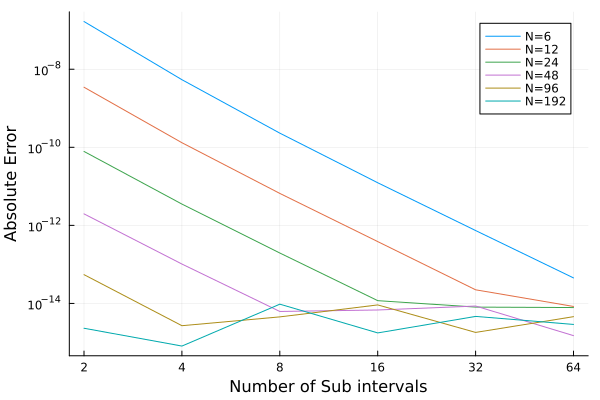

In [6]:
# Example 1: y'= , y(0)=1; T in [0, T]

using Plots

y0 = 1.0 

lambda=  1.0im

tspan=[0 1]


f(t, y)=  lambda * y 



# Exact Solution

exact = y0*exp(lambda*tspan[2])

p=6 # Parameter for various N values

q=6 # subinterval varying parameter

err = zeros(ComplexF64, p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        
        y = y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err[n, j] = abs(exact - y)
        
    end
    
end
plot(nsub, abs.(err[1, :]), xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, abs.(err[l, :]), xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

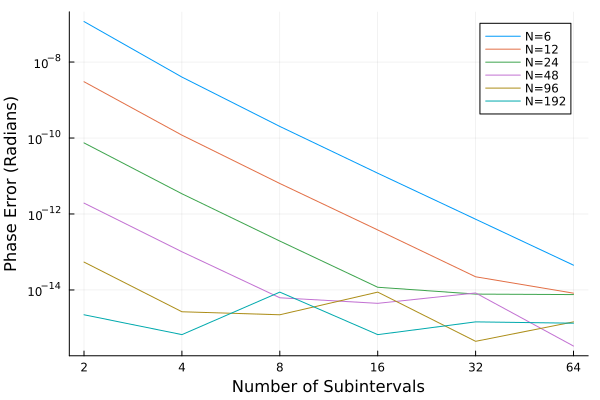

In [5]:
using Plots

# Function to compute the phase angle (argument) of a complex number
phase_angle(z) = atan(imag(z), real(z))


# Example 1: y' = lambda * y, y(0) = 1, T in [0, T]

# Define parameters
y0 = 1.0 
lambda = 1.0im
tspan = [0 1]
exact = y0 * exp(lambda * tspan[2])

# Define the function
f(t, y) = lambda * y

# Initialize arrays to store errors and subintervals
p = 6
q = 6

err_phase = zeros(Float64, p, q)
nsub = zeros(q)

# Loop over different N values
for n = 1:p
    N = 6 * 2^(n - 1)
    
    # Loop over different numbers of subintervals
    for j = 1:q
        sub = 2^j
        nsub[j] = sub
        
        ds = tspan[2] / sub
        
        # Compute numerical solution
        y = y0
        for i = 1:sub
            t0 = (i - 1) * ds
            tf = i * ds
            y = ridc_step(f, [t0 tf], y, N)
        end
        # Compute phase error
        phase_numerical = phase_angle(y)
        phase_exact =  phase_angle(exact)
        err_phase[n, j] = abs(phase_exact - phase_numerical)
        
    end
end
# Plot phase error
plot(nsub, err_phase[1, :], xaxis=:log, yaxis=:log, label="N=$(6 * 2^(1 - 1))", ylabel="Phase Error (Radians)", xlabel="Number of Subintervals", xticks=nsub, xformatter=x -> string(Int(round(x))))
for l in 2:p
    plot!(nsub, err_phase[l, :], xaxis=:log, yaxis=:log, label="N=$(6 * 2^(l - 1))", xticks=nsub, xformatter=x -> string(Int(round(x))))
end
display(plot!(legend=:topright))